In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from xgboost import XGBClassifier
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
from sklearn.ensemble import GradientBoostingClassifier
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold , StratifiedKFold
import lightgbm
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
def preprocess(df):

    del df['Unnamed: 0']
    del df['customerID']
    df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
    
    
    #Code labels

    df["Churn"].replace({"Yes": 1, "No": 0}, inplace=True)
    df.dropna(axis=0,inplace=True)

    for col in df.columns.tolist():
        #print(col)
        if df[col].dtype == object:
            df[col] = df[col].fillna(df[col].mode()[0])
            #Get Dummies
            df = pd.get_dummies(df, columns=[col])
        else:
            df[col] = df[col].fillna(df[col].mean())   
           
        print("done col=",col)
    
   
    
    
    return df

In [3]:
# Loading data
data = pd.read_csv('../input/telecom-users-dataset/telecom_users.csv')
data.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,...,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,...,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


<AxesSubplot:xlabel='Churn', ylabel='count'>

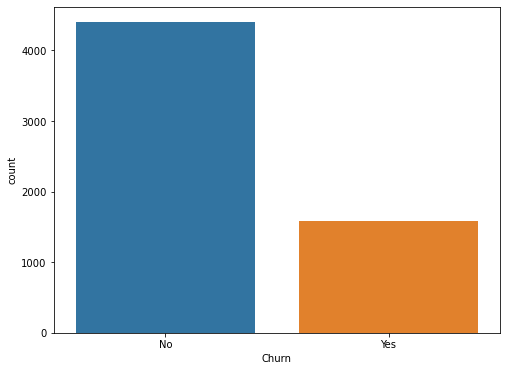

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x=data['Churn'],ax=ax)

Figure above demonstrates that our dataset is imbalanced in terms of number of Churned obs. But, in still worth trying to build model without resampling.

<AxesSubplot:xlabel='gender', ylabel='count'>

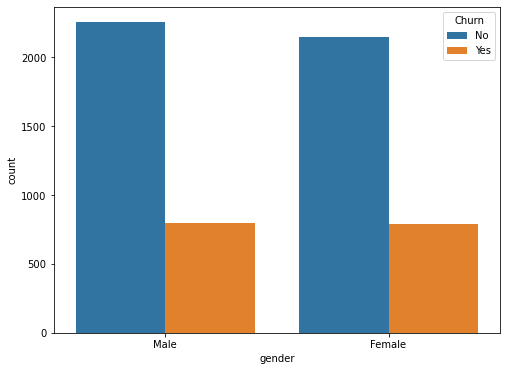

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x=data['gender'], hue=data['Churn'],ax=ax)

Regarding gender of an user, its evident that number of churns remains stable across all genders

<AxesSubplot:xlabel='InternetService', ylabel='count'>

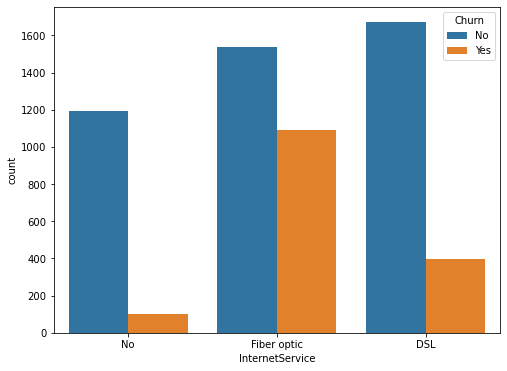

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x=data['InternetService'], hue=data['Churn'],ax=ax)

<AxesSubplot:xlabel='PhoneService', ylabel='count'>

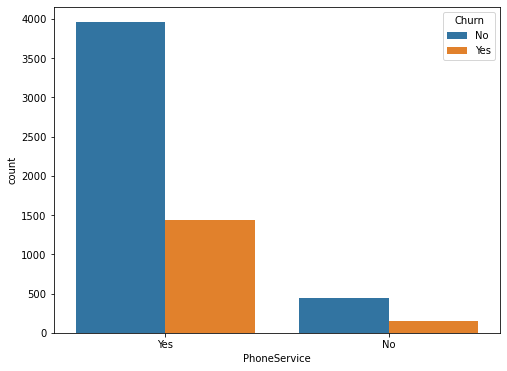

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x=data['PhoneService'], hue=data['Churn'],ax=ax)

<AxesSubplot:xlabel='StreamingMovies', ylabel='count'>

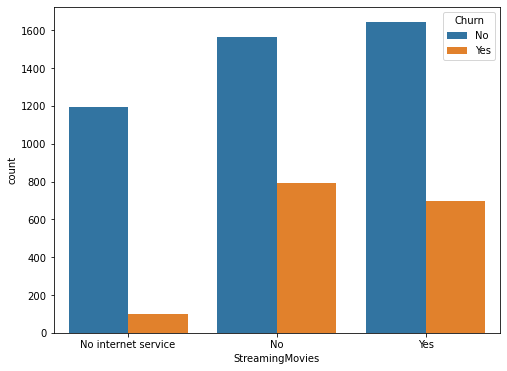

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x=data['StreamingMovies'], hue=data['Churn'],ax=ax)

Figure above shows that users without internet service are less likely to stop using telecom, due to their inability to access internet without telecom service.

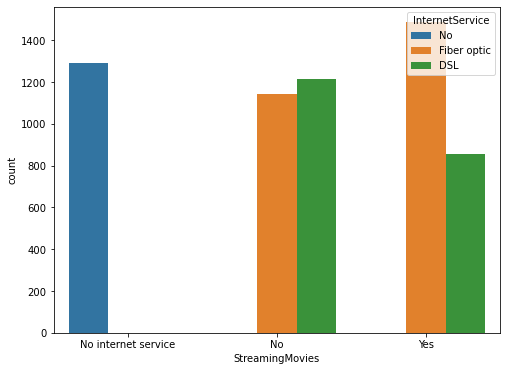

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x=data['StreamingMovies'], hue=data['InternetService'],ax=ax)
plt.show()

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        5986 non-null   int64  
 1   customerID        5986 non-null   object 
 2   gender            5986 non-null   object 
 3   SeniorCitizen     5986 non-null   int64  
 4   Partner           5986 non-null   object 
 5   Dependents        5986 non-null   object 
 6   tenure            5986 non-null   int64  
 7   PhoneService      5986 non-null   object 
 8   MultipleLines     5986 non-null   object 
 9   InternetService   5986 non-null   object 
 10  OnlineSecurity    5986 non-null   object 
 11  OnlineBackup      5986 non-null   object 
 12  DeviceProtection  5986 non-null   object 
 13  TechSupport       5986 non-null   object 
 14  StreamingTV       5986 non-null   object 
 15  StreamingMovies   5986 non-null   object 
 16  Contract          5986 non-null   object 


In [11]:
data = preprocess(data)

done col= gender
done col= SeniorCitizen
done col= Partner
done col= Dependents
done col= tenure
done col= PhoneService
done col= MultipleLines
done col= InternetService
done col= OnlineSecurity
done col= OnlineBackup
done col= DeviceProtection
done col= TechSupport
done col= StreamingTV
done col= StreamingMovies
done col= Contract
done col= PaperlessBilling
done col= PaymentMethod
done col= MonthlyCharges
done col= TotalCharges
done col= Churn


In [12]:
labels = data['Churn']
del data['Churn']
X_train,X_test,y_train,y_test = sk.model_selection.train_test_split(data,labels)

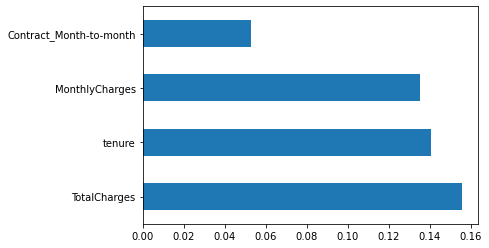

In [13]:
# Feature selection using select from model

import numpy as np
from sklearn.linear_model import LassoCV

lasso = RandomForestClassifier().fit(X_train, y_train)
importance = np.abs(lasso.feature_importances_)
feature_names = X_train.columns.tolist()
(pd.Series(lasso.feature_importances_, index=X_train.columns)
   .nlargest(4)
   .plot(kind='barh')) 


#Feature selection from model Lasso
from sklearn.feature_selection import SelectFromModel
from time import time

threshold = np.sort(importance)[-40] + 0.01

tic = time()
sfm = SelectFromModel(lasso, threshold=threshold).fit(X_train, y_train)



In [14]:
X_transform = sfm.transform(data)

# Oversampling with smote
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_transform, labels = oversample.fit_resample(X_transform, labels)


X_train,X_test,y_train,y_test = sk.model_selection.train_test_split(X_transform,labels)

In [15]:
print("Selected Features")

for i in range(0,len(sfm.get_support())):
    if sfm.get_support()[i]==True:
       print(data.columns.tolist()[i])

Selected Features
SeniorCitizen
tenure
MonthlyCharges
TotalCharges
gender_Female
gender_Male
Partner_No
Partner_Yes
MultipleLines_No
MultipleLines_Yes
InternetService_Fiber optic
OnlineSecurity_No
OnlineBackup_No
DeviceProtection_No
TechSupport_No
TechSupport_Yes
Contract_Month-to-month
Contract_Two year
PaperlessBilling_No
PaperlessBilling_Yes
PaymentMethod_Electronic check


In [16]:
# Tuning with optuna
def objective(trial , data = X_transform , target = labels):
    X_train , X_test , y_train , y_test = train_test_split(data , target , \
            test_size = 0.31 , random_state = 420)
    
    params = {
        'reg_alpha' : trial.suggest_loguniform('reg_alpha' , 1e-5 , 10),
        'reg_lambda' : trial.suggest_loguniform('reg_lambda' , 1e-5 , 10),
        'num_leaves' : trial.suggest_int('num_leaves' , 11 , 300),
        'learning_rate' : trial.suggest_uniform('learning_rate' , 0 , 0.1),
        'max_depth' : trial.suggest_int('max_depth' , 5 , 20),
        'n_estimators' : trial.suggest_int('n_estimators' , 1 , 9999),
        'min_child_samples' : trial.suggest_int('min_child_samples' , 1 , 100),
        'min_child_weight' : trial.suggest_loguniform('min_child_weight' , 1e-5 , 1),
        'subsample' : trial.suggest_uniform('subsample' , 0 , 1.0),
        'colsample_bytree' : trial.suggest_loguniform('colsample_bytree' , 1e-5 , 1),
        'random_state' : trial.suggest_categorical('random_state' , [0,42,2021,555]),
        'metric' : 'auc',
        'device_type' : 'gpu',
        #'tree_method': 'gpu_hist',
        #'eval_metric': 'logloss' 
    }
    model = lightgbm.LGBMClassifier(**params)
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test,preds).ravel()
    score = tp/(tp+fp)

    return score

In [17]:
study = optuna.create_study(direction = 'maximize' , study_name = 'Gbt')
study.optimize(objective , n_trials = 20)
print('numbers of the finished trials:' , len(study.trials))
print('the best params:' , study.best_trial.params)
print('the best value:' , study.best_value)

[I 2021-03-25 03:55:15,690] A new study created in memory with name: Gbt
[I 2021-03-25 03:55:56,025] Trial 0 finished with value: 0.8477272727272728 and parameters: {'reg_alpha': 2.3077939404386842e-05, 'reg_lambda': 1.421945092349684, 'num_leaves': 55, 'learning_rate': 0.047538631418534316, 'max_depth': 11, 'n_estimators': 5214, 'min_child_samples': 8, 'min_child_weight': 0.0010356367886300616, 'subsample': 0.3668594494101882, 'colsample_bytree': 0.6090068959020448, 'random_state': 2021}. Best is trial 0 with value: 0.8477272727272728.
[I 2021-03-25 03:56:00,843] Trial 1 finished with value: 0.8681572860447185 and parameters: {'reg_alpha': 2.1940761011629495, 'reg_lambda': 0.026203613691357437, 'num_leaves': 141, 'learning_rate': 0.08253751224081417, 'max_depth': 13, 'n_estimators': 5496, 'min_child_samples': 7, 'min_child_weight': 0.17766373138191746, 'subsample': 0.05916629226977199, 'colsample_bytree': 0.000451744715619963, 'random_state': 0}. Best is trial 1 with value: 0.86815728

numbers of the finished trials: 20
the best params: {'reg_alpha': 6.618046474803032, 'reg_lambda': 8.096367232367153e-05, 'num_leaves': 94, 'learning_rate': 0.02338601975738591, 'max_depth': 15, 'n_estimators': 3554, 'min_child_samples': 17, 'min_child_weight': 0.00012574899392224593, 'subsample': 0.6735102388702205, 'colsample_bytree': 0.0019774566180396375, 'random_state': 42}
the best value: 0.8739495798319328


In [18]:
import plotly
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
optuna.visualization.plot_optimization_history(study)

In [20]:
optuna.visualization.plot_param_importances(study)

In [21]:
optuna.visualization.plot_parallel_coordinate(study)

In [22]:
#model = XGBClassifier(**study.best_trial.params)
model = lightgbm.LGBMClassifier(**study.best_trial.params)

model.fit(X_train,y_train)
pred = model.predict(X_test)

0.8596810933940775


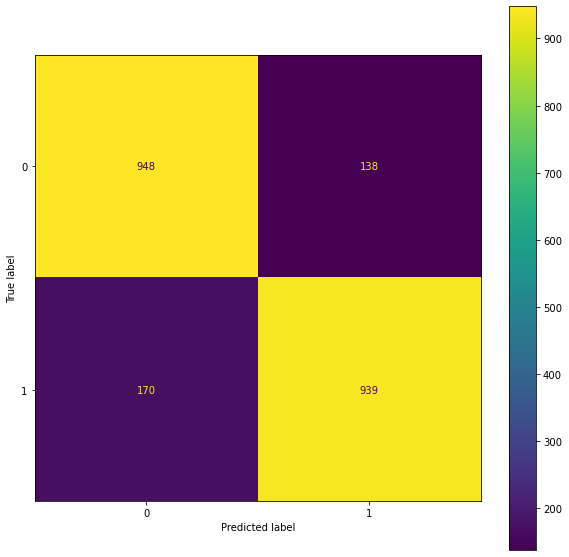

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
metrics.plot_confusion_matrix(model,X_test,y_test,ax=ax)
print(metrics.accuracy_score(y_test,pred))

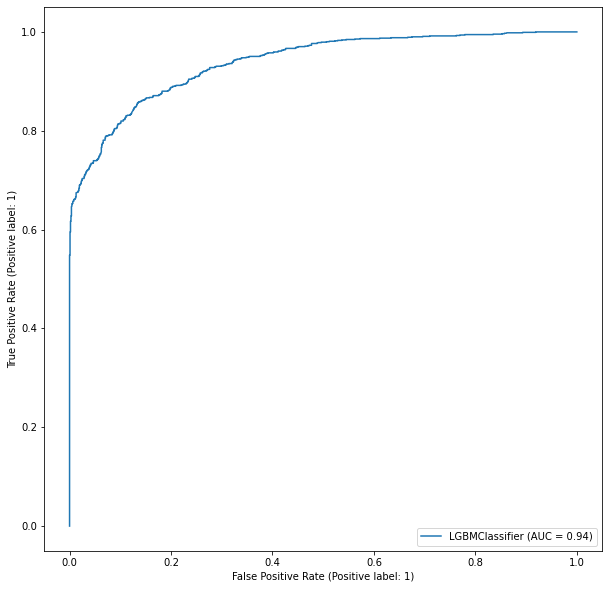

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
metrics.plot_roc_curve(model,X_test,y_test,ax=ax)

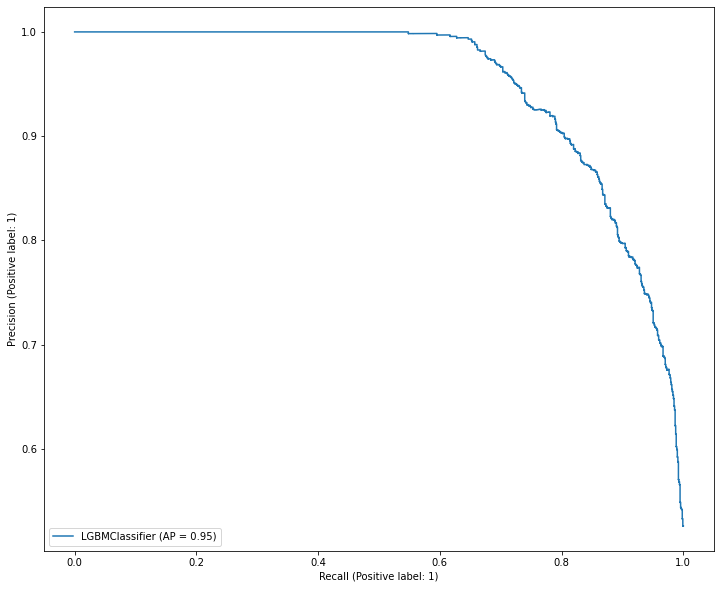

In [25]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

fig, ax = plt.subplots(figsize=(12, 10))
plot_precision_recall_curve(model,X_test,y_test,ax=ax)